# KeyPhase and Entity Extraction

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import spacy
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn import set_config

tqdm.pandas()
nlp = spacy.load('en_core_web_lg')
set_config(display="diagram")

In [2]:
df = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv', delimiter=',', encoding='latin-1', header=None).fillna('')
df = df.rename(columns=lambda x: ['sentiment', 'text'][x])
print(df.shape)
df.head()

(4846, 2)


,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
class EntityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [[ent.text for ent in nlp(x).ents] for x in X]
    
    
class KeyPhaseExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def __noun_verb_noun(self, doc):
            phrases = []
            for token in doc:
                if (token.pos_=='VERB'):
                    phrase = ''
                    for sub_tok in token.lefts:
                        if (sub_tok.dep_ in ['nsubj','nsubjpass']) and (sub_tok.pos_ in ['NOUN','PROPN','PRON']):
                            phrase += sub_tok.text
                            phrase += ' '+token.lemma_ 
                            for sub_tok in token.rights:
                                if (sub_tok.dep_ in ['dobj']) and (sub_tok.pos_ in ['NOUN','PROPN']):       
                                    phrase += ' '+sub_tok.text
                                    phrases.append(phrase)

            return phrases
        
    def __adjective_noun(self, doc):
        phrases = []

        for token in doc:
            phrase = ''
            if (token.pos_ == 'NOUN') and (token.dep_ in ['dobj','pobj','nsubj','nsubjpass']):
                for subtoken in token.children:
                    if (subtoken.pos_ == 'ADJ') or (subtoken.dep_ == 'compound'):
                        phrase += subtoken.text + ' '
                if len(phrase)!=0:
                    phrase += token.text 
            if  len(phrase)!=0:
                phrases.append(phrase)
        return phrases      
    
    def __prepositions(self, doc):
        phrases = []

        for token in doc:
            if token.pos_=='ADP':
                phrase = ''
                if token.head.pos_=='NOUN':
                    phrase += token.head.text
                    phrase += ' '+token.text
                    for right_tok in token.rights:
                        if (right_tok.pos_ in ['NOUN','PROPN']):
                            phrase += ' '+right_tok.text

                    if len(phrase)>2:
                        phrases.append(phrase)

        return phrases

    def transform(self, X, y=None):
        return [(self.__noun_verb_noun(nlp(x.lower())) + self.__adjective_noun(nlp(x.lower())) + self.__prepositions(nlp(x.lower()))) for x in X]

In [4]:
def identity_tokenizer(x):
    return x

get_model = lambda: Pipeline([
    ('vectorizer', FeatureUnion([
        ('entities', Pipeline([
            ('extractor', EntityExtractor()), 
            ('vectorizer', TfidfVectorizer(tokenizer=identity_tokenizer, use_idf=False, sublinear_tf=True, lowercase=False))
        ])),
        ('kphrases', Pipeline([
            ('extractor', KeyPhaseExtractor()),
            ('vectorizer', TfidfVectorizer(tokenizer=identity_tokenizer, sublinear_tf=True, lowercase=False))
        ])),
        ('vanilatf', TfidfVectorizer(sublinear_tf=True))
    ])),
    ('estimator', LogisticRegression(max_iter=100_000, random_state=19, class_weight="balanced"))
])
get_model()

Pipeline(steps=[('vectorizer',
                 FeatureUnion(transformer_list=[('entities',
                                                 Pipeline(steps=[('extractor',
                                                                  EntityExtractor()),
                                                                 ('vectorizer',
                                                                  TfidfVectorizer(lowercase=False,
                                                                                  sublinear_tf=True,
                                                                                  tokenizer=<function identity_tokenizer at 0x7fc04dff19e0>,
                                                                                  use_idf=False))])),
                                                ('kphrases',
                                                 Pipeline(steps=[('extractor',
                                                                  KeyPhaseExtractor()),
                                                                 ('vectorizer',
                                                                  TfidfVectorizer(lowercase=False,
                                                                                  sublinear_tf=True,
                                                                                  tokenizer=<function identity_tokenizer at 0x7fc04dff19e0>))])),
                                                ('vanilatf',
                                                 TfidfVectorizer(sublinear_tf=True))])),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=100000,
                                    random_state=19))])

In [5]:
x = df['text']
y = df['sentiment']

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=19)
scores = []
models = []
for train_index, valid_index in tqdm(skf.split(x, y), total=10):
    x_train, x_valid = x.iloc[train_index], x.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    model = get_model().fit(x_train, y_train)
    scores.append(model.score(x_valid, y_valid))
    models.append(model)
print(np.mean(scores))

  0%|          | 0/10 [00:00<?, ?it/s]

0.7577353667887875


In [6]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

def plot_feature_importance(model, ax, fold):
    coefs = minmax_scale(model.named_steps['estimator'].coef_.mean(axis=0), feature_range=(-1,1))
    n_features = [
        len(model.named_steps['vectorizer'].transformer_list[0][1].named_steps['vectorizer'].get_feature_names_out()),
        len(model.named_steps['vectorizer'].transformer_list[1][1].named_steps['vectorizer'].get_feature_names_out()),
        len(model.named_steps['vectorizer'].transformer_list[2][1].get_feature_names_out())
    ]
    v_lines = np.cumsum(n_features)[:-1]
    ax.plot(coefs)
    for x in v_lines:
        ax.axvline(x=x, color = 'r')
    ax.set_title(f"Feature Importance fold {fold+1}")

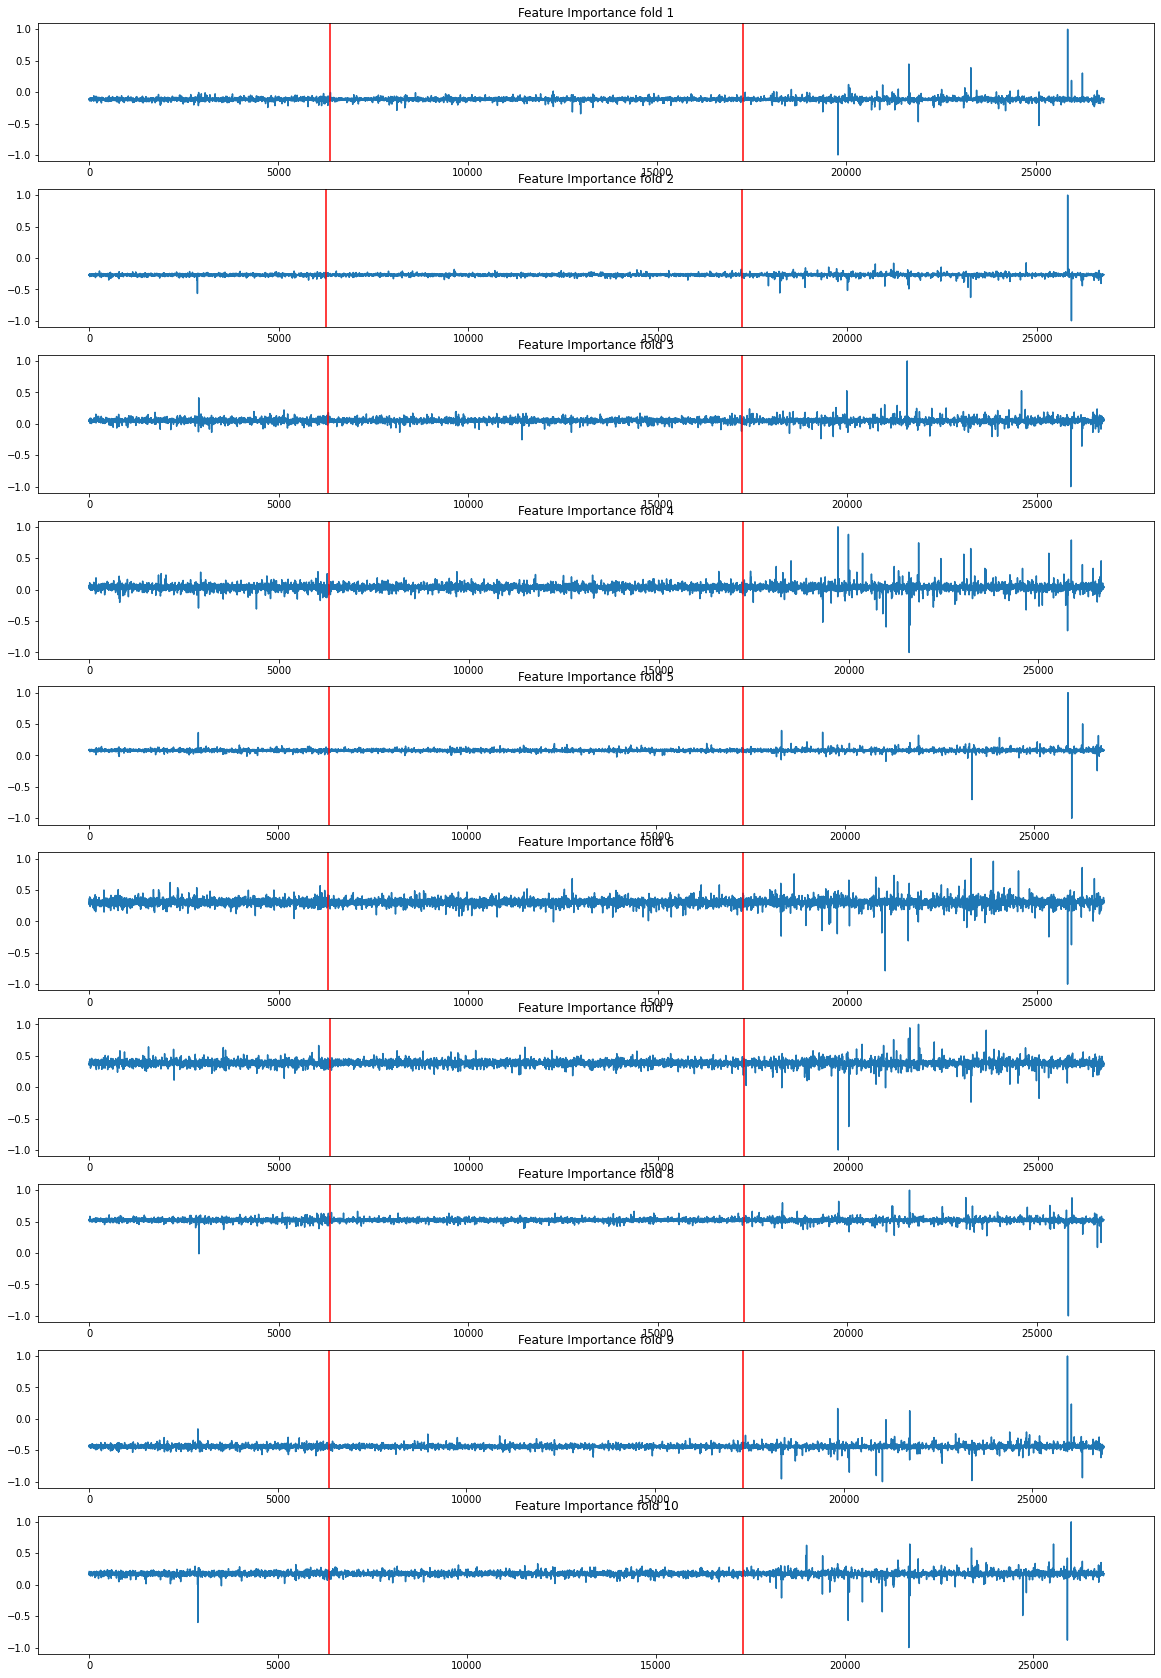

In [7]:
fig, ax = plt.subplots(10, 1, figsize=(20, 30))
for i in range(10):
    plot_feature_importance(models[i], ax[i], i)